In [1]:
# 导入需要的包
import os
import torch
import numpy as np
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from mxtorch import transforms as tfs
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

(500, 281)
(500, 375)


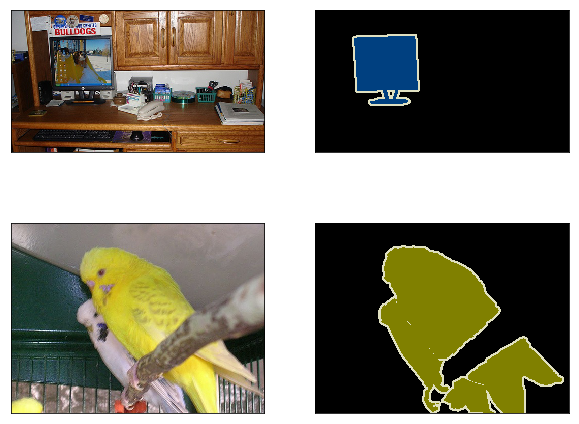

In [2]:
im_show1 = Image.open('./data/VOCdevkit/VOC2012/JPEGImages/2007_005210.jpg')
label_show1 = Image.open('./data/VOCdevkit/VOC2012/SegmentationClass/2007_005210.png').convert('RGB')
im_show2 = Image.open('./data/VOCdevkit/VOC2012/JPEGImages/2007_000645.jpg')
label_show2 = Image.open('./data/VOCdevkit/VOC2012/SegmentationClass/2007_000645.png').convert('RGB')

_ , figs = plt.subplots(2,2, figsize = (10,8))
figs[0][0].imshow(im_show1)
figs[0][0].axes.get_xaxis().set_visible(False)
figs[0][0].axes.get_yaxis().set_visible(False)
figs[0][1].imshow(label_show1)
figs[0][1].axes.get_xaxis().set_visible(False)
figs[0][1].axes.get_yaxis().set_visible(False)
figs[1][0].imshow(im_show2)
figs[1][0].axes.get_xaxis().set_visible(False)
figs[1][0].axes.get_yaxis().set_visible(False)
figs[1][1].imshow(label_show2)
figs[1][1].axes.get_xaxis().set_visible(False)
figs[1][1].axes.get_yaxis().set_visible(False)
print(im_show1.size)
print(im_show2.size)

In [3]:
voc_root = './data/VOCdevkit/VOC2012'

#返回图片的路径
def read_images(root = voc_root,train = True):
    txt_fname = voc_root + '/ImageSets/Segmentation/' +('train.txt' if train else 'val.txt')
    with open(txt_fname,'r') as f:
        images = f.read().split()
    data = [os.path.join(root,'JPEGImages',i+'.jpg') for i in images]
    label = [os.path.join(root,'SegmentationClass',i+'.png') for i in images]
    return data,label
    

对于输入图片我们当然可以 resize 成任意我们想要的大小，但是 label 也是一张图片，且是在 pixel 级别上的标注，所以我们没有办法对label 进行有效的 resize 似的其也能达到像素级别的匹配，所以为了使得输入的图片大小相同，我们就使用 crop 的方式来解决这个问题，也就是从一张图片中 crop 出固定大小的区域，然后在 label 上也做同样方式的 crop

使用 crop 可以使用 pytorch 中自带的 transforms，不过要稍微改一下，不仅输出 crop 出来的区域，同时还要输出对应的坐标便于我们在 label 上做相同的 crop

In [4]:
#crop
def random_crop(data,label,crop_size):
    #height , width = crop_size
    data , rect = tfs.RandomCrop(crop_size)(data)
    label = tfs.FixedCrop(*rect)(label)
    return data,label

(300, 200)
(300, 200)


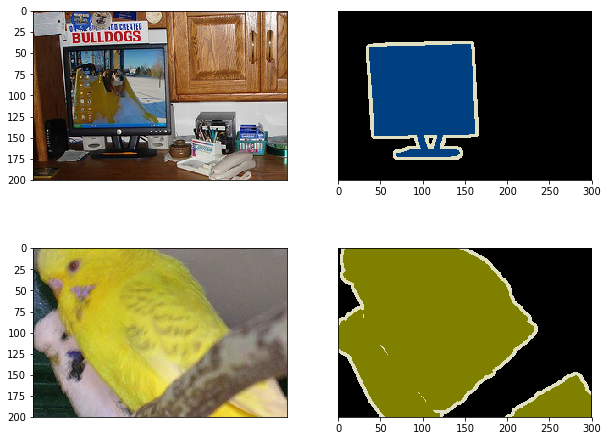

In [5]:
_ , figs = plt.subplots(2,2,figsize = (10,8))
crop_im1 , crop_label1 = random_crop(im_show1,label_show1,(200,300))
figs[0][0].imshow(crop_im1)
figs[0][1].imshow(crop_label1)
figs[0][0].axes.get_xaxis().set_visible(False)
figs[0][1].axes.get_yaxis().set_visible(False)
crop_im2, crop_label2 = random_crop(im_show2, label_show2, (200, 300))
figs[1][0].imshow(crop_im2)
figs[1][1].imshow(crop_label2)
figs[1][0].axes.get_xaxis().set_visible(False)
figs[1][1].axes.get_yaxis().set_visible(False)
print(crop_im1.size)
print(crop_label1.size)

In [6]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']

# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

In [7]:
#根据RGB建立索引，将label用 h*w的数字表示
cm2lbl = np.zeros(256**3)
for i , cm in enumerate(colormap):
    cm2lbl[(cm[0]*256 + cm[1])*256 + cm[2]] = i
    
def image2label(img):
    data = np.array(img,dtype = 'int32')
    #print(data.shape)
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    #print(idx.shape)
    #print(cm2lbl[idx].shape)
    return np.array(cm2lbl[idx],dtype='int64')# 根据索引得到 label 矩阵 为什么索引还能是矩阵？？？？

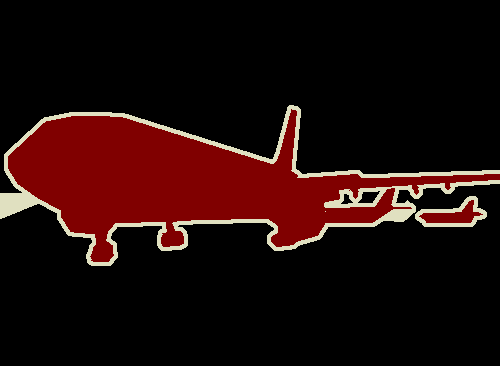

In [8]:
label_im = Image.open('./data/VOCdevkit/VOC2012/SegmentationClass/2007_000033.png').convert('RGB')
label_im

In [9]:
label = image2label(label_im)
label.shape

(366, 500)

In [10]:
label[150:160, 240:250]#飞机部分之label为1

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [11]:
def img_transforms(img,label,crop_size):
    img , label = random_crop(img,label,crop_size)
    img_tfs = tfs.Compose([tfs.ToTensor(),tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])#mean and std
    
    img = img_tfs(img)
    label = image2label(label)
    label = torch.from_numpy(label)#将label变为Tensor()
    return img,label
    

In [12]:
#定义一个 VOCSegDataset 继承于 torch.utils.data.Dataset 构成我们自定的训练集
class VOCSegDataset(Dataset):
    def __init__(self,train,crop_size,transforms):
        self.crop_size = crop_size
        self.transforms = transforms
        data_list,label_list = read_images(train=train)#返回路径
        self.data_list = self._filter(data_list)
        self.label_list = self._filter(label_list)
        print('Read ' + str(len(self.data_list)) + ' images')
        
    def _filter(self,images):
        return [im for im in images if (Image.open(im).size[0] >= self.crop_size[1] and 
                                        Image.open(im).size[1] >= self.crop_size[0] )]#crop_size->h*w image_size->w*h
    
    def __getitem__(self,idx):
        img_path = self.data_list[idx]
        label_path = self.label_list[idx]
        img = Image.open(img_path)
        label = Image.open(label_path).convert('RGB')
        img , label = self.transforms(img,label,self.crop_size)
        return img , label
    
    def __len__(self):
        return len(self.data_list)
        

In [13]:
# 实例化数据集
input_shape = (320, 480)
voc_train = VOCSegDataset(True, input_shape, img_transforms)
voc_test = VOCSegDataset(False, input_shape, img_transforms)

train_data = DataLoader(voc_train, 64, shuffle=True, num_workers=4)
valid_data = DataLoader(voc_test, 128, num_workers=4)
print(voc_train[0])

Read 1114 images
Read 1078 images
(
( 0 ,.,.) = 
  0.8276  1.0844  0.9817  ...  -0.6109 -0.6452 -0.6281
  0.7248  1.0844  1.1015  ...  -0.5596 -0.6109 -0.5767
  0.6392  0.9988  1.1700  ...  -0.5253 -0.5596 -0.5424
           ...             ⋱             ...          
 -0.3369 -0.3369 -0.3541  ...  -0.5082 -0.5424 -0.5424
 -0.3369 -0.3541 -0.3541  ...  -0.5767 -0.5082 -0.5253
 -0.3369 -0.3369 -0.3712  ...  -0.6109 -0.5767 -0.5767

( 1 ,.,.) = 
  1.0280  1.2906  1.1681  ...  -0.4776 -0.5476 -0.5301
  0.9230  1.2731  1.2906  ...  -0.4251 -0.5301 -0.4951
  0.8179  1.1856  1.3606  ...  -0.3901 -0.4776 -0.4601
           ...             ⋱             ...          
 -0.2150 -0.1800 -0.1975  ...  -0.1975 -0.2500 -0.2500
 -0.2150 -0.1975 -0.1975  ...  -0.2675 -0.2325 -0.2500
 -0.2150 -0.1975 -0.2150  ...  -0.3025 -0.3025 -0.3025

( 2 ,.,.) = 
  1.0539  1.3154  1.1934  ...  -0.5670 -0.6367 -0.6193
  0.9494  1.2980  1.3154  ...  -0.5147 -0.5670 -0.5321
  0.8448  1.2108  1.3851  ...  -0.4450 -0.5

In [14]:
x = torch.randn(1,3,120,120)
#print(x.type)
conv_trans = nn.ConvTranspose2d(3,10,4,stride = 2,padding = 1)
y = conv_trans(Variable(x))
y.size()

torch.Size([1, 10, 240, 240])

In [15]:
#FCN-8S
# 定义 bilinear kernel
def bilinear_kernel(in_channels,out_channels,kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size,:kernel_size]#制作一个网格
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels,out_channels,kernel_size,kernel_size),dtype = 'float32')
    weight[range(in_channels),range(out_channels),:,:] = filt
    return torch.from_numpy(weight)

In [16]:
og = np.ogrid[:4,:4]
print(og[0].shape)
print(og[1].shape)
(1 - abs(og[0] - 1) / 2) * (1 - abs(og[1] - 1) / 2)

(4, 1)
(1, 4)


array([[ 0.25,  0.5 ,  0.25,  0.  ],
       [ 0.5 ,  1.  ,  0.5 ,  0.  ],
       [ 0.25,  0.5 ,  0.25,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

(281, 500, 3)


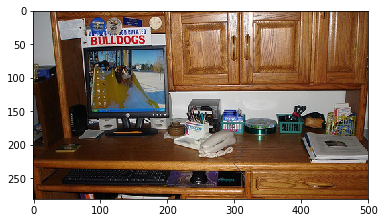

In [17]:
x = Image.open('./data/VOCdevkit/VOC2012/JPEGImages/2007_005210.jpg')
x = np.array(x)
plt.imshow(x)
print(x.shape)

(561, 999, 3)


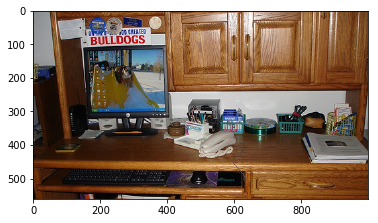

In [18]:
x = torch.from_numpy(x.astype('float32')).permute(2, 0, 1).unsqueeze(0)
# 定义转置卷积
conv_trans = nn.ConvTranspose2d(3, 3, 3, 2, 1)
# 将其定义为 bilinear kernel
conv_trans.weight.data = bilinear_kernel(3, 3, 3)

y = conv_trans(Variable(x)).data.squeeze().permute(1, 2, 0).numpy()
plt.imshow(y.astype('uint8'))
print(y.shape)

In [19]:
from mxtorch.vision import model_zoo
# 使用预训练的 resnet 34
pretrained_net = model_zoo.resnet34(pretrained=True)

num_classes = len(classes)

In [20]:
pretrained_net
#[3,4,6,3]层 从layeri 到layer(i+1)需要下采样 stride = 2

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [21]:
len(list(pretrained_net.children()))
#list(pretrained_net.children())[-3:-1]
list(pretrained_net.children())[-3]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d (256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (downsample): Sequential(
      (0): Conv2d (256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d (512, 512, kernel_size=(3, 3), st

In [22]:
#去掉最后两层 avgpool 和 fc
class fcn(nn.Module):
    def __init__(self,num_classes):
        super(fcn,self).__init__()
        
        self.stage1 = nn.Sequential(*list(pretrained_net.children())[:-4])#第一段
        #将两层结果专门取出来
        self.stage2 = list(pretrained_net.children())[-4]
        self.stage3 = list(pretrained_net.children())[-3]
        
        self.scores1 = nn.Conv2d(512,num_classes,1)
        self.scores2 = nn.Conv2d(256,num_classes,1)
        self.scores3 = nn.Conv2d(128,num_classes,1)
        
        self.upsample_8x = nn.ConvTranspose2d(num_classes,num_classes,16,8,4,bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(num_classes,num_classes,16)
        
#         self.upsample_4x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)
#         self.upsample_4x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel
        
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)   
        self.upsample_2x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel
        
    def forward(self,x):
        x = self.stage1(x)
        s1 = x # 1 / 8 3个stride = 2
        
        x = self.stage2(x)
        s2 = x #1 / 16
        
        x = self.stage3(x)
        s3 = x #1 / 32
        
        s3 = self.scores1(s3)
        s3 = self.upsample_2x(s3)
        s2 = self.scores2(s2)
        s2 = s2 + s3
        
        s2 = self.upsample_2x(s2)
        s1 = self.scores3(s1)
        s = s1 + s2
        
        s = self.upsample_8x(s)
        return s

In [23]:
net = fcn(num_classes)
#net.cpu()
net.cuda()

fcn(
  (stage1): Sequential(
    (0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [24]:
from mxtorch.vision.eval_tools import eval_semantic_segmentation

#loss and optimizer
from mxtorch.trainer import ScheduledOptim

criterion = nn.NLLLoss2d()
basic_optim = torch.optim.Adam(net.parameters(),lr = 1e-2,weight_decay=1e-4)
optimizer = ScheduledOptim(basic_optim)

In [26]:
from datetime import datetime

for e in range(80):
    if e > 0 and e % 50 == 0:
        optimizer.set_learning_rate(optimizer.learning_rate * 0.1)
    train_loss = 0
    train_acc = 0
    train_mean_iu = 0
    
    prev_time = datetime.now()
    net = net.train()#训练前要加这一句
    for data in train_data:
#         im = Variable(data[0].cuda())
#         labels = Variable(data[1].cuda())
        im = Variable(data[0].cuda())
        labels = Variable(data[1].cuda())
        #forward
        out = net(im)
        out = F.log_softmax(out,dim = 1) #(b,n,h,w) 在维度1上操作
        #NLLLoss2d:
        #Input: (N,C,H,W)  where C = number of classes
        #Target: (N,H,W)   where each value is 0 <= targets[i] <= C-1
        loss = criterion(out,labels)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()#a.max(dim=1)[1]在每个像素点上产生类别
        pred_labels = [i for i in pred_labels]
        
        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]
        
        eval_metrics = eval_semantic_segmentation(pred_labels,true_labels)
        train_acc += eval_metrics['mean_class_accuracy']
        train_mean_iu += eval_metrics['miou']
        
    net = net.eval()
    eval_loss = 0
    eval_acc = 0
    eval_mean_iu = 0
    for data in valid_data:
        im = Variable(data[0].cuda(),volatile=True)#volatile=True固定参数 不保存中间变量 inference常用
        labels = Variable(data[1].cuda(),volatile = True)
        #forward
        out = net(im)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, labels)
        eval_loss += loss.data[0]
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()
        pred_labels = [i for i in pred_labels]

        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]

        eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)

        eval_acc += eval_metrics['mean_class_accuracy']
        eval_mean_iu += eval_metrics['miou']
    
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, \
Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f}'.format(e,train_loss / len(train_data), train_acc / len(train_data), train_mean_iu / len(train_data),
        eval_loss / len(valid_data), eval_acc / len(valid_data), eval_mean_iu / len(valid_data)))
    time_str = 'Time: {:.0f}:{:.0f}:{:.0f}'.format(h, m, s)
    print(epoch_str + time_str + ' lr: {}'.format(optimizer.learning_rate))

/home/ai/Downloads/FCN-pytorch/mxtorch/vision/eval_tools/eval_semantic_segmentation.py:96: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/home/ai/Downloads/FCN-pytorch/mxtorch/vision/eval_tools/eval_semantic_segmentation.py:175: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


Epoch: 0, Train Loss: 1.39799, Train Acc: 0.04965, Train Mean IU: 0.03608, Valid Loss: 1.46928, Valid Acc: 0.04762, Valid Mean IU: 0.03465Time: 0:0:23 lr: 0.01
Epoch: 1, Train Loss: 1.31649, Train Acc: 0.04871, Train Mean IU: 0.03542, Valid Loss: 1.31805, Valid Acc: 0.04766, Valid Mean IU: 0.03475Time: 0:0:24 lr: 0.01
Epoch: 2, Train Loss: 1.29566, Train Acc: 0.04971, Train Mean IU: 0.03596, Valid Loss: 2.85972, Valid Acc: 0.06147, Valid Mean IU: 0.04075Time: 0:0:24 lr: 0.01
Epoch: 3, Train Loss: 1.26125, Train Acc: 0.04917, Train Mean IU: 0.03585, Valid Loss: 1.30438, Valid Acc: 0.04777, Valid Mean IU: 0.03484Time: 0:0:24 lr: 0.01
Epoch: 4, Train Loss: 1.24172, Train Acc: 0.05048, Train Mean IU: 0.03681, Valid Loss: 1.21943, Valid Acc: 0.04887, Valid Mean IU: 0.03599Time: 0:0:24 lr: 0.01
Epoch: 5, Train Loss: 1.28769, Train Acc: 0.05182, Train Mean IU: 0.03790, Valid Loss: 1.26038, Valid Acc: 0.04789, Valid Mean IU: 0.03499Time: 0:0:24 lr: 0.01
Epoch: 6, Train Loss: 1.24902, Train Acc

Epoch: 51, Train Loss: 0.91168, Train Acc: 0.13562, Train Mean IU: 0.09697, Valid Loss: 0.99303, Valid Acc: 0.09993, Valid Mean IU: 0.07475Time: 0:0:23 lr: 0.001
Epoch: 52, Train Loss: 0.89482, Train Acc: 0.13937, Train Mean IU: 0.10036, Valid Loss: 0.99807, Valid Acc: 0.08857, Valid Mean IU: 0.06722Time: 0:0:23 lr: 0.001
Epoch: 53, Train Loss: 0.88532, Train Acc: 0.13825, Train Mean IU: 0.10113, Valid Loss: 0.97884, Valid Acc: 0.11137, Valid Mean IU: 0.08255Time: 0:0:23 lr: 0.001
Epoch: 54, Train Loss: 0.88228, Train Acc: 0.14565, Train Mean IU: 0.10803, Valid Loss: 0.98256, Valid Acc: 0.10536, Valid Mean IU: 0.07702Time: 0:0:23 lr: 0.001
Epoch: 55, Train Loss: 0.88124, Train Acc: 0.14321, Train Mean IU: 0.10443, Valid Loss: 0.97575, Valid Acc: 0.11005, Valid Mean IU: 0.08092Time: 0:0:23 lr: 0.001
Epoch: 56, Train Loss: 0.87215, Train Acc: 0.16020, Train Mean IU: 0.11481, Valid Loss: 0.96572, Valid Acc: 0.12371, Valid Mean IU: 0.09046Time: 0:0:23 lr: 0.001
Epoch: 57, Train Loss: 0.864

In [27]:
a = np.random.random((4,7,3,3))
a = torch.from_numpy(a)
print(a)
print(a.max(dim=1)[0])
print(a.max(dim=1)[1])
#F.log_softmax(a,dim = 1)


(0 ,0 ,.,.) = 
  0.5169  0.4707  0.0544
  0.5524  0.9269  0.1548
  0.1106  0.3674  0.4736

(0 ,1 ,.,.) = 
  0.2902  0.8563  0.5275
  0.6338  0.5259  0.0949
  0.0617  0.8993  0.3230

(0 ,2 ,.,.) = 
  0.7049  0.6932  0.8371
  0.0641  0.4050  0.6252
  0.5058  0.3908  0.2167

(0 ,3 ,.,.) = 
  0.7033  0.5959  0.2443
  0.3086  0.9887  0.0964
  0.5575  0.9462  0.7102

(0 ,4 ,.,.) = 
  0.3282  0.9078  0.7840
  0.8402  0.8751  0.8965
  0.3417  0.4646  0.7098

(0 ,5 ,.,.) = 
  0.4639  0.5970  0.5365
  0.0494  0.2683  0.5701
  0.8964  0.3346  0.7436

(0 ,6 ,.,.) = 
  0.0780  0.8836  0.1326
  0.0414  0.6164  0.0255
  0.8813  0.3078  0.4036

(1 ,0 ,.,.) = 
  0.7041  0.0928  0.5211
  0.7836  0.3658  0.3662
  0.1143  0.7774  0.0020

(1 ,1 ,.,.) = 
  0.4265  0.4261  0.7552
  0.3549  0.3330  0.0490
  0.4147  0.0793  0.5141

(1 ,2 ,.,.) = 
  0.1941  0.9242  0.7075
  0.2866  0.6638  0.2141
  0.6505  0.6982  0.9666

(1 ,3 ,.,.) = 
  0.2726  0.7989  0.5817
  0.7688  0.8465  0.6317
  0.4942  0.7113  0.2469

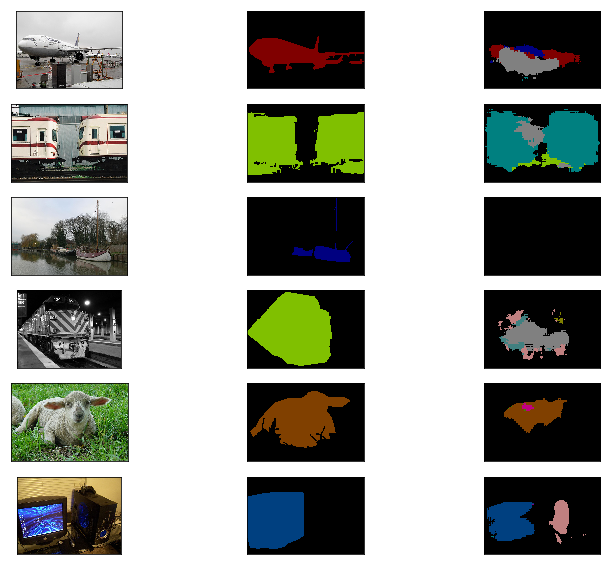

In [30]:
net = net.eval()#测试模式

cm = np.array(colormap).astype('uint8')

def predict(img,label):
    img = Variable(img.unsqueeze(0)).cuda()
    out = net(img)
    pred = out.max(dim = 1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred,cm[label.numpy()]

_ , figs = plt.subplots(6,3,figsize = (12,10))
for i in range(6):
    test_data, test_label = voc_test[i]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(voc_test.data_list[i]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)

In [24]:
from mxtorch.vision.eval_tools import eval_semantic_segmentation

#loss and optimizer
from mxtorch.trainer import ScheduledOptim

criterion = nn.NLLLoss2d()
basic_optim = torch.optim.RMSprop(net.parameters(),lr = 1e-2,weight_decay=1e-4)
optimizer = ScheduledOptim(basic_optim)

In [25]:
from datetime import datetime

for e in range(80):
    if e > 0 and e % 50 == 0:
        optimizer.set_learning_rate(optimizer.learning_rate * 0.1)
    train_loss = 0
    train_acc = 0
    train_mean_iu = 0
    
    prev_time = datetime.now()
    net = net.train()#训练前要加这一句
    for data in train_data:
#         im = Variable(data[0].cuda())
#         labels = Variable(data[1].cuda())
        im = Variable(data[0].cuda())
        labels = Variable(data[1].cuda())
        #forward
        out = net(im)
        out = F.log_softmax(out,dim = 1) #(b,n,h,w) 在维度1上操作
        #NLLLoss2d:
        #Input: (N,C,H,W)  where C = number of classes
        #Target: (N,H,W)   where each value is 0 <= targets[i] <= C-1
        loss = criterion(out,labels)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()#a.max(dim=1)[1]在每个像素点上产生类别
        pred_labels = [i for i in pred_labels]
        
        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]
        
        eval_metrics = eval_semantic_segmentation(pred_labels,true_labels)
        train_acc += eval_metrics['mean_class_accuracy']
        train_mean_iu += eval_metrics['miou']
        
    net = net.eval()
    eval_loss = 0
    eval_acc = 0
    eval_mean_iu = 0
    for data in valid_data:
        im = Variable(data[0].cuda(),volatile=True)#volatile=True固定参数 不保存中间变量 inference常用
        labels = Variable(data[1].cuda(),volatile = True)
        #forward
        out = net(im)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, labels)
        eval_loss += loss.data[0]
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()
        pred_labels = [i for i in pred_labels]

        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]

        eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)

        eval_acc += eval_metrics['mean_class_accuracy']
        eval_mean_iu += eval_metrics['miou']
    
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, \
Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f}'.format(e,train_loss / len(train_data), train_acc / len(train_data), train_mean_iu / len(train_data),
        eval_loss / len(valid_data), eval_acc / len(valid_data), eval_mean_iu / len(valid_data)))
    time_str = 'Time: {:.0f}:{:.0f}:{:.0f}'.format(h, m, s)
    print(epoch_str + time_str + ' lr: {}'.format(optimizer.learning_rate))

/home/ai/Downloads/FCN-pytorch/mxtorch/vision/eval_tools/eval_semantic_segmentation.py:96: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/home/ai/Downloads/FCN-pytorch/mxtorch/vision/eval_tools/eval_semantic_segmentation.py:175: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


Epoch: 0, Train Loss: 156.94484, Train Acc: 0.05093, Train Mean IU: 0.02401, Valid Loss: 1021820.10417, Valid Acc: 0.04848, Valid Mean IU: 0.00376Time: 0:0:33 lr: 0.01
Epoch: 1, Train Loss: 6.16187, Train Acc: 0.05498, Train Mean IU: 0.03227, Valid Loss: 127.19161, Valid Acc: 0.04893, Valid Mean IU: 0.03555Time: 0:0:23 lr: 0.01
Epoch: 2, Train Loss: 3.53943, Train Acc: 0.05082, Train Mean IU: 0.03588, Valid Loss: 1.63151, Valid Acc: 0.05069, Valid Mean IU: 0.03701Time: 0:0:23 lr: 0.01
Epoch: 3, Train Loss: 1.76019, Train Acc: 0.05168, Train Mean IU: 0.03548, Valid Loss: 1.40637, Valid Acc: 0.04768, Valid Mean IU: 0.03474Time: 0:0:23 lr: 0.01
Epoch: 4, Train Loss: 1.80068, Train Acc: 0.04882, Train Mean IU: 0.03488, Valid Loss: 2.02132, Valid Acc: 0.05977, Valid Mean IU: 0.03259Time: 0:0:23 lr: 0.01
Epoch: 5, Train Loss: 1.68050, Train Acc: 0.05127, Train Mean IU: 0.03476, Valid Loss: 1.51832, Valid Acc: 0.05718, Valid Mean IU: 0.03692Time: 0:0:23 lr: 0.01
Epoch: 6, Train Loss: 1.41597,

Epoch: 51, Train Loss: 1.22843, Train Acc: 0.04882, Train Mean IU: 0.03548, Valid Loss: 1.23645, Valid Acc: 0.04762, Valid Mean IU: 0.03462Time: 0:0:24 lr: 0.001
Epoch: 52, Train Loss: 1.21845, Train Acc: 0.04901, Train Mean IU: 0.03567, Valid Loss: 1.22645, Valid Acc: 0.04762, Valid Mean IU: 0.03470Time: 0:0:23 lr: 0.001
Epoch: 53, Train Loss: 1.21498, Train Acc: 0.04908, Train Mean IU: 0.03574, Valid Loss: 1.22455, Valid Acc: 0.04762, Valid Mean IU: 0.03468Time: 0:0:23 lr: 0.001
Epoch: 54, Train Loss: 1.21082, Train Acc: 0.04918, Train Mean IU: 0.03592, Valid Loss: 1.23007, Valid Acc: 0.04763, Valid Mean IU: 0.03466Time: 0:0:23 lr: 0.001
Epoch: 55, Train Loss: 1.20558, Train Acc: 0.04919, Train Mean IU: 0.03583, Valid Loss: 1.22192, Valid Acc: 0.04820, Valid Mean IU: 0.03533Time: 0:0:23 lr: 0.001
Epoch: 56, Train Loss: 1.19274, Train Acc: 0.04982, Train Mean IU: 0.03660, Valid Loss: 1.22153, Valid Acc: 0.04769, Valid Mean IU: 0.03477Time: 0:0:24 lr: 0.001
Epoch: 57, Train Loss: 1.200

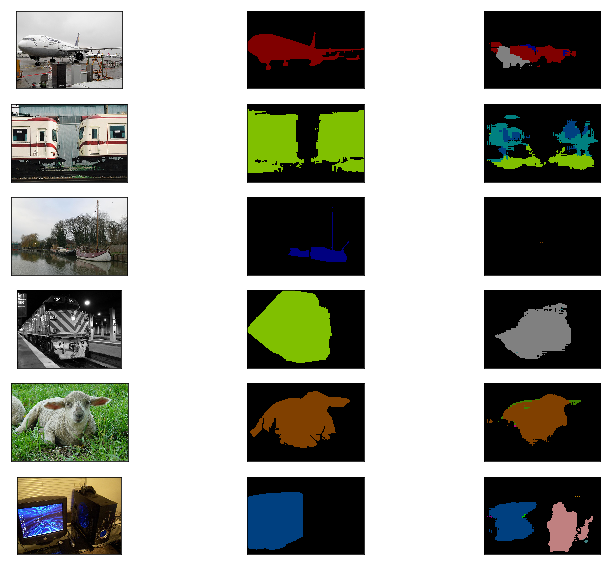

In [34]:
net = net.eval()#测试模式

cm = np.array(colormap).astype('uint8')

def predict(img,label):
    img = Variable(img.unsqueeze(0)).cuda()
    out = net(img)
    pred = out.max(dim = 1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred,cm[label.numpy()]

_ , figs = plt.subplots(6,3,figsize = (12,10))
for i in range(6):
    test_data, test_label = voc_test[i]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(voc_test.data_list[i]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)